In [50]:
# 📌 Step 1: Import Libraries
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


In [51]:
# 📌 Step 2: Load Dataset
# (replace with your actual CSV name)
df = pd.read_csv("Amazon Sale Report.csv", encoding="utf-8", on_bad_lines="skip")

print("✅ Data Loaded")
print(df.head())

✅ Data Loaded
   index             Order ID      Date                        Status  \
0      0  405-8078784-5731545  04-30-22                     Cancelled   
1      1  171-9198151-1101146  04-30-22  Shipped - Delivered to Buyer   
2      2  404-0687676-7273146  04-30-22                       Shipped   
3      3  403-9615377-8133951  04-30-22                     Cancelled   
4      4  407-1069790-7240320  04-30-22                       Shipped   

  Fulfilment Sales Channel  ship-service-level    Style              SKU  \
0   Merchant      Amazon.in           Standard   SET389   SET389-KR-NP-S   
1   Merchant      Amazon.in           Standard  JNE3781  JNE3781-KR-XXXL   
2     Amazon      Amazon.in          Expedited  JNE3371    JNE3371-KR-XL   
3   Merchant      Amazon.in           Standard    J0341       J0341-DR-L   
4     Amazon      Amazon.in          Expedited  JNE3671  JNE3671-TU-XXXL   

        Category  ... currency  Amount    ship-city   ship-state  \
0            Set  ... 

/tmp/ipython-input-2961836659.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Amazon Sale Report.csv", encoding="utf-8", on_bad_lines="skip")


In [52]:
df.shape

(128975, 24)

In [53]:
df.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [55]:
df.drop(["promotion-ids", "B2B", "fulfilled-by", "Unnamed: 22", "currency",
         "ship-postal-code", "index", "Order ID", "Fulfilment",
         "ship-service-level", "Style", "SKU", "ASIN", "Courier Status","Sales Channel ","ship-country","Amount","Status","Size","ship-city","ship-state"],
        axis=1, inplace=True)

In [56]:
# 📌 Step 3: Preprocess Dates
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

/tmp/ipython-input-3221513024.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [57]:
df.isna().sum()

,0
Date,0
Category,0
Qty,0
Year,0
Month,0


ValueError: could not convert string to float: 'kurta'

In [58]:
dupe=df.duplicated()
print(dupe.sum())
df=df[~dupe]
dupe=df.duplicated()
print(dupe.sum())

127540
0


In [59]:
df.drop("Date",axis=1,inplace=True)

In [60]:
#step 4 Remove rows where Qty is 0
df = df[df['Qty'] != 0].copy()

print("Shape after removing Qty=0:", df.shape)
print("Any Qty=0 left?", (df['Qty'] == 0).sum())


Shape after removing Qty=0: (928, 4)
Any Qty=0 left? 0


In [61]:
df

,Category,Qty,Year,Month
1,kurta,1,2022,4
4,Top,1,2022,4
5,Set,1,2022,4
30,Western Dress,1,2022,4
40,Ethnic Dress,1,2022,4
...,...,...,...,...
127410,Saree,1,2022,6
127625,Blouse,1,2022,6
128404,Set,2,2022,6
128584,Bottom,1,2022,6


In [62]:
#step 5 : Encoding
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
le = LabelEncoder()

# Fit on categories
df['Category_code'] = le.fit_transform(df['Category'])

# Save the encoder for later use
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [63]:
# 📌 Step 6: Monthly Demand (Target Column)
monthly_demand = df.groupby(['Category', 'Year', 'Month'])['Qty'].sum().reset_index()
print("✅ Monthly Demand created")
print(monthly_demand.head())

✅ Monthly Demand created
  Category  Year  Month  Qty
0   Blouse  2022      3    1
1   Blouse  2022      4   54
2   Blouse  2022      5   33
3   Blouse  2022      6   29
4   Bottom  2022      4   31


In [64]:
monthly_demand.tail()

,Category,Year,Month,Qty
26,Western Dress,2022,6,49
27,kurta,2022,3,1
28,kurta,2022,4,134
29,kurta,2022,5,92
30,kurta,2022,6,93


In [65]:
# 📌 Step 7: Define Features and Target
X = monthly_demand[['Category', 'Year', 'Month']]
y = monthly_demand['Qty']
X['Category'] = X['Category'].map(X['Category'].value_counts())


/tmp/ipython-input-2342992362.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Category'] = X['Category'].map(X['Category'].value_counts())


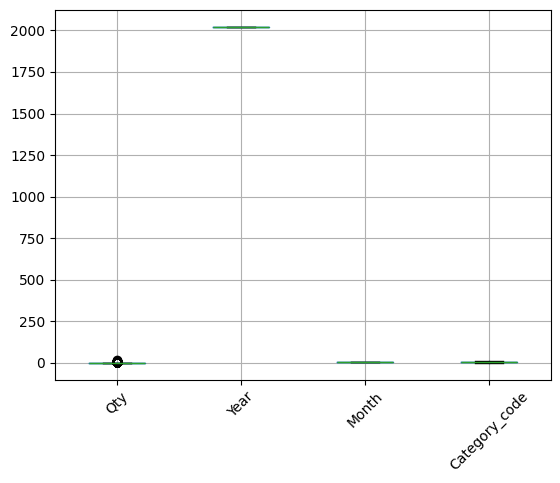

In [66]:
import matplotlib.pyplot as plt
df.boxplot()
plt.xticks(rotation=45)
plt.show()

In [67]:
# Step 8: Train-Test Split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [68]:
# step 9 : hyperparameter tuning for a Random Forest Regressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
search = RandomizedSearchCV(rf, params, n_iter=20, cv=3, scoring='r2', n_jobs=-1)
search.fit(X_train, y_train)

print("Best Params:", search.best_params_)


Best Params: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}


In [69]:
# 📌 Step 10: Train Model
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=None,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 922.7713
R-squared (R²): 0.3688


In [70]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)


MAPE: 3.457247737634799


In [71]:
lr=LinearRegression() #lr is an instance of the LinearRegression class.
model=lr.fit(X_train,y_train)
predictions=model.predict(X_test)
mse_lin=mean_squared_error(y_test,predictions)
r2_lin=r2_score(y_test,predictions)
print(f"Mean Squared Error (MSE): {mse_lin:.4f}")
print(f"R-squared (R²): {r2_lin:.4f}")

Mean Squared Error (MSE): 1516.7540
R-squared (R²): -0.0376


In [72]:
from xgboost import XGBRegressor

In [73]:
xmodel = XGBRegressor(objective='reg:squarederror', n_estimators=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) and R-squared (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost Model Performance:")
print("-" * 30)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")



XGBoost Model Performance:
------------------------------
Mean Squared Error (MSE): 1516.7540
R-squared (R²): -0.0376


In [74]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error (MSE) and R-squared (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("LightGBM Model Performance:")
print("-" * 30)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("-" * 30)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 0
[LightGBM] [Info] Start training from score 43.166667
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

In [75]:
print("✅ Model Training Complete")
print("R2 Score:", model.score(X_test, y_test))

# 📌 Step 11: Save Model and LabelEncoder
with open("demand_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model & Encoder Saved")

✅ Model Training Complete
R2 Score: -0.11603184575053893
✅ Model & Encoder Saved


In [76]:
# Safety Stock = Sum of Qty grouped by Category
safety_stock = df.groupby("Category")["Qty"].sum().reset_index()
safety_stock.columns = ["Category", "Safety_Stock"]

# Average Monthly Demand (rounded to int)
inventory_estimate = (
    monthly_demand.groupby("Category")["Qty"].mean().round().astype(int).reset_index()
)
inventory_estimate.columns = ["Category", "Estimated_Inventory"]

# Merge both
inventory_df = pd.merge(inventory_estimate, safety_stock, on="Category")
inventory_df["Safety_Stock"] = inventory_df["Safety_Stock"].astype(int)
inventory_df["Estimated_Inventory"] = inventory_df["Estimated_Inventory"].astype(int)

# 📌 Save to CSV
inventory_df.to_csv("inventory.csv", index=False)
print("✅ inventory.csv created successfully!")

print("📦 Inventory Table:")
print(inventory_df.head())

✅ inventory.csv created successfully!
📦 Inventory Table:
       Category  Estimated_Inventory  Safety_Stock
0        Blouse                   29           117
1        Bottom                   31            92
2       Dupatta                    1             1
3  Ethnic Dress                   24            95
4         Saree                   24            72
